In [19]:
import os
import xlwings
import numpy as np
import pandas as pd 

In [20]:

# 获得表格分数数据
def Get_Score_Table_info(Score_Table_Class):
      # 分数表格-类别 
    # print(Score_Table_Class)  

    Course_target_class = np.array(Score_Table_Class.iloc[5,4:-1])  # 课程目标类别
    # print(course_target_class) 
    Student_score = np.array(Score_Table_Class.iloc[8:,4:-1]) # 学生分数（各题）
    # Student_score[:,0]
    Student_info = np.array(Score_Table_Class.iloc[8:,2:4])       # 学生信息 

    Score_Table_Head = Score_Table_Class.iloc[:8,:] # 表头数据

    # 课程目标 类别 
    loc_target_Numall=np.array([])
    loc_target_one = np.argwhere(Course_target_class==1).reshape((-1)) # 满足条件的索引值 
    loc_target_two = np.argwhere(Course_target_class==2).reshape((-1)) # 满足条件的索引值 
    loc_target_three = np.argwhere(Course_target_class==3).reshape((-1)) # 满足条件的索引值 
    # print(loc_target_one,loc_target_two,loc_target_three)
    loc_target_Numall=[loc_target_one, loc_target_two, loc_target_three] 
    # print('loc_target_Numall', loc_target_Numall) 

    # 每题满分 
    Fullscore_each_examination_question = np.array((Score_Table_Class.iloc[6,4:-1])).reshape((-1)) 
    # print(Fullscore_each_examination_question)
    return Student_score, Fullscore_each_examination_question, loc_target_Numall, Student_info, Course_target_class, Score_Table_Head


In [21]:
# 达成度目标=NUM 计算
### 数据索引
# 学生分数
def Achievement_Degree_Calcultion_function(Student_score, Fullscore_each_examination_question, 
                                           loc_target_Num, RATIO_SCORE_CLASS):  
    scorelist_student_target_Num=[] 

    for i in range(len(loc_target_Num)): 
        scorelist_student_target_Num.append( Student_score[:,loc_target_Num[i]] ) 
    scorearr_target_Num = np.array(scorelist_student_target_Num).T 
    # print('学生分数', scorearr_target_Num) 

    # 每题题目分数 
    FullscoreEEQ_list_target_Num=[] 
    for i in range(len(loc_target_Num)):   
        FullscoreEEQ_list_target_Num.append(Fullscore_each_examination_question[loc_target_Num[i]] )  

    # print('每题题目分数', FullscoreEEQ_list_target_Num)

    ### 数据计算
    # 实际满分(百分制) - 比例满分 - 学生得分 - 得分比例 - 目标1得分
    RealFullscore_target_Num_Total = sum(FullscoreEEQ_list_target_Num) / np.sum(Fullscore_each_examination_question)  *100  # 实际满分(百分制)
    # print('实际满分(百分制)', RealFullscore_target_Num_Total)
    # 比例满分 (乘以比例后的分数) 
    RatioFullscore_target_Num = RealFullscore_target_Num_Total * RATIO_SCORE_CLASS 
    # 学生得分(百分制)
    Score_student_target_Num_Total = np.sum(scorearr_target_Num, axis=1) / np.sum(Fullscore_each_examination_question) *100 # 实际得分(百分制)
    
    # 得分比例
    Ratio_score_target_Num = np.around((Score_student_target_Num_Total/RealFullscore_target_Num_Total).astype(float) ,decimals=4)
    # print( Ratio_score_target_Num ) 
    # 目标1得分 = 比例满分 * 得分比例 
    Score_target_Num =np.around( ( RatioFullscore_target_Num * Ratio_score_target_Num).astype(float) ,decimals=4)
    # print(Score_target_Num)
    

    return np.c_[Score_student_target_Num_Total, Ratio_score_target_Num, Score_target_Num], RealFullscore_target_Num_Total, RatioFullscore_target_Num 
    

In [22]:
# 获得新的表头
def Score_Table_Head_Deal(Score_Table_Head):
    w_table = Score_Table_Head.shape[1]
    Table_Head = Score_Table_Head
    # print(w_table)
    new_col = Table_Head.columns.to_list() + list(range(w_table,w_table+3*3+2))
    Table_Head = Table_Head.reindex(columns=new_col)
    namecol_add = ['1', '1°','1得分','2', '2°','2得分','3', '3°','3得分', '计算成绩', '实际成绩']

    Table_Head.iloc[1,w_table:] = namecol_add
    Table_Head.drop(columns=[0,1],axis=1,inplace=True)
    Table_Head.columns = list(range(0,Table_Head.shape[1]))
    return Table_Head

In [23]:
# 整体平均分 + 各项学生得分占比
def AverageScore_ScoreRatio(DataScore_Cal_CourseClass_Num, Fullscore_each_examination_question):
    Score_Average =  np.around(np.mean(DataScore_Cal_CourseClass_Num[:,2:],axis = 0).astype(float),decimals=2) 
    # print(Score_Average) 
    FS_EEQ_T = np.r_[Fullscore_each_examination_question, np.sum(Fullscore_each_examination_question)]
    # print(FS_EEQ_T.shape) 
    W_scoreratio = np.around( (Score_Average[:-11]/FS_EEQ_T ).astype(float) , decimals=2 )
    # print(W_scoreratio) 
    Score_Average_str = np.r_[np.nan, np.array('平均分'), Score_Average ] 
    W_scoreratio_str  = np.r_[np.nan, np.array('得分率'), W_scoreratio,  np.full((11), np.nan) ] 
    Score_Average_str = Score_Average_str.reshape(-1, len(Score_Average_str))
    W_scoreratio_str  = W_scoreratio_str.reshape(-1, len(W_scoreratio_str))
    return Score_Average_str, W_scoreratio_str

In [24]:
# 获得EXCEL==含指定字符
def get_excel_file(specified_character ='成绩表模板'): 
    excel_name =''
    for i in (os.listdir()):
        if i.split('.')[-1] == 'xlsx' or i.split('.')[-1] == 'xls':
            if specified_character in i.split('.')[0]:
                excel_name = i
    if excel_name=='':        
        print('当前文件夹下, 无excel文件') 
        print('or 无指定字符(%s)的.xlsx或xls文件'%specified_character)
    else:
        return excel_name

In [25]:

# 主函数 - 课程类别（期末成绩-实验成绩-平时成绩）
def main_Achievement_Degree_Calcultion_CourseClassNum(Score_table, RATIO_SCORE_CLASS): 
    # 获得表格分数数据 
    Student_score, Fullscore_each_examination_question, loc_target_Numall, Student_info, Course_target_class, Score_Table_Head \
            = Get_Score_Table_info(Score_Table_Class = Score_table) 

    # 计算达成度数据
    for TargetNum in [1,2,3]: 
        res_ADC, RealFullscore, RatioFullscore = Achievement_Degree_Calcultion_function(Student_score, Fullscore_each_examination_question, 
                                                loc_target_Numall[TargetNum-1], RATIO_SCORE_CLASS) 

        if TargetNum==1:
            Calresult_target_Numall = np.c_[res_ADC]
            RealFullscore_target_all  = np.c_[RealFullscore]
            RatioFullscore_target_all = np.c_[RatioFullscore]
        elif TargetNum>1:
            Calresult_target_Numall = np.c_[Calresult_target_Numall, res_ADC]                                        
            RealFullscore_target_all  = np.c_[RealFullscore_target_all, RealFullscore]
            RatioFullscore_target_all = np.c_[RatioFullscore_target_all, RatioFullscore]

    RealFullscore_target_all,RatioFullscore_target_all = RealFullscore_target_all[0], RatioFullscore_target_all[0] 

    # 计算总分 + 实际总分
    ScoreTotal_Cal_CourseClass_Num = np.around( np.sum(Calresult_target_Numall[:,2::3] , axis=1).astype(float), decimals=2) 
    # print(ScoreTotal_Cal_CourseClass_Num )   
     
    Student_score_percentage = np.sum(Student_score, axis=1) / np.sum(Fullscore_each_examination_question) *100  # 百分制
    ScoreTotal_Real_CourseClass_Num = np.around( ( Student_score_percentage * RATIO_SCORE_CLASS).astype(float), decimals=2) 
    # print(ScoreTotal_Real_CourseClass_Num)  

    # 拼接所有数据-1
    DataScore_Cal_CourseClass_Num = np.c_[Student_info, Student_score, Student_score_percentage ,np.around(Calresult_target_Numall.astype(float), decimals=2), \
                                    ScoreTotal_Cal_CourseClass_Num, ScoreTotal_Real_CourseClass_Num]

    Score_Average_str, W_scoreratio_str = AverageScore_ScoreRatio(DataScore_Cal_CourseClass_Num, Fullscore_each_examination_question)

    # 拼接所有数据-2
    DataScore_Cal_all_CourseClass_Num = np.r_[DataScore_Cal_CourseClass_Num, Score_Average_str, W_scoreratio_str]
    # print(DataScore_Cal_all_CourseClass_Num)

    # 最终结果表格写入excel
    # 数据表头 
    Final_Table_Head = Score_Table_Head_Deal(Score_Table_Head=Score_Table_Head)
    Final_Table_Head.iloc[6,-3*3-2:-2:3] = RealFullscore_target_all
    Final_Table_Head.iloc[7,-3*3-2:-2:3] = RatioFullscore_target_all
    # 拼接表头与数据
    DataScore_Cal_df=pd.DataFrame(DataScore_Cal_all_CourseClass_Num)
    Result_table_Final = pd.concat([Final_Table_Head,DataScore_Cal_df]) 
    return Result_table_Final


In [26]:
# 自动载入  '成绩表模板' 
ExcelName = get_excel_file(specified_character ='成绩表模板') 
ExcelName_path = os.path.join(os.getcwd(), ExcelName)  # 打开的excel必须关闭，否则没有权限 Permission denied 

for sheetname in ['平时成绩','实验成绩','期末成绩']: 
    Score_table = pd.read_excel(ExcelName_path, index_col=None, header=None, sheet_name=sheetname) 

    if sheetname == '平时成绩':
        RATIO_pingshi_score = Score_table.iloc[1,4] # 平时成绩比例
        ADC_ScoreClass_pingshi = main_Achievement_Degree_Calcultion_CourseClassNum(Score_table, RATIO_SCORE_CLASS = RATIO_pingshi_score)
    elif sheetname == '实验成绩':
        RATIO_shiyan_score =  Score_table.iloc[1,4] # 实验成绩比例
        ADC_ScoreClass_shiyan = main_Achievement_Degree_Calcultion_CourseClassNum(Score_table, RATIO_SCORE_CLASS = RATIO_shiyan_score)
    elif sheetname == '期末成绩':
        RATIO_qimo_score = Score_table.iloc[1,4] # 期末成绩比例
        ADC_ScoreClass_qimo = main_Achievement_Degree_Calcultion_CourseClassNum(Score_table, RATIO_SCORE_CLASS = RATIO_qimo_score)

with pd.ExcelWriter('课程达成度评价结果.xlsx', mode='w') as writer: 
    ADC_ScoreClass_pingshi.to_excel(writer, sheet_name='平时成绩',header=False,index=False,startrow=0, startcol=0)
    ADC_ScoreClass_shiyan.to_excel(writer, sheet_name='实验成绩',header=False,index=False,startrow=0, startcol=0)
    ADC_ScoreClass_qimo.to_excel(writer, sheet_name='期末成绩',header=False,index=False,startrow=0, startcol=0)

In [27]:
### 达成度分析表 函数库开始
# ADC_calss 数据抽取 + 计算
def Data_Summary_ADC_Target_num(targetnum, 
                ADCData_pingshi_arr, # 平时作业  ADC计算结果
                ADCData_shiyan_arr,  # 实验      ADC计算结果
                ADCData_qimo_arr,    # 期末      ADC计算结果   
                ADC_RatioFullScore_pingshi_arr,  # 课程目标比例满分-平时
                ADC_RatioFullScore_shiyan_arr,   # 课程目标比例满分-实验
                ADC_RatioFullScore_qimo_arr      # 课程目标比例满分-期末
    ):
    ### 数据表
    #数据抽取 - ADC-Targetnum-res 
    Target_num_ADC_Scoreclassall = np.c_[ ADCData_pingshi_arr[:,targetnum-1], ADCData_shiyan_arr[:,targetnum-1],  
                                                                            ADCData_qimo_arr[:,targetnum-1]  ] 
    # 求和  
    Target_num_ADC_Scoreclassall_sum = np.sum(Target_num_ADC_Scoreclassall, axis = 1)  
    # 达成度比例
    Target_num_ADC_RatioFullScore_Scoreclassall = np.c_[ADC_RatioFullScore_pingshi_arr[targetnum-1], 
                                                        ADC_RatioFullScore_shiyan_arr[targetnum-1],
                                                        ADC_RatioFullScore_qimo_arr[targetnum-1] ]
    Target_num_ADC_RatioFullScore_Scoreclassall_sum = np.sum(Target_num_ADC_RatioFullScore_Scoreclassall, axis = 1)  # 目标1- 
    Target_num_ADC_ratio_W  = np.around((Target_num_ADC_Scoreclassall_sum / Target_num_ADC_RatioFullScore_Scoreclassall_sum).astype(float), decimals=2)

    # 达成度汇总
    Target_num_ADC_data_x = np.c_[ Target_num_ADC_Scoreclassall, Target_num_ADC_Scoreclassall_sum, Target_num_ADC_ratio_W] 
    Target_num_ADC_data_x_mean = np.expand_dims( np.around( np.mean(Target_num_ADC_data_x, axis=0).astype(float),  decimals=2)  , axis=0 )   # 一维转置 == 拓展0维即可
    Ratiovalue_ADC = np.expand_dims( np.array([Target_num_ADC_data_x_mean[0,-1], np.nan, np.nan, np.nan, np.nan]), axis=0 ) 
    Target_num_ADC_data_all_df = pd.DataFrame( np.r_[Target_num_ADC_data_x, Target_num_ADC_data_x_mean, Ratiovalue_ADC] )

    ###表头
 
    Head_str_row0 = [ '课程目标{}(满分{}分)'.format(targetnum, Target_num_ADC_RatioFullScore_Scoreclassall_sum[0]), '', '', '','']

    Head_str_row1 = [ '平时得分','实验得分', '期末得分' , '小计', '课程目标达成情况']

    Head_str_row2 = ['满分{}分'.format(ADC_RatioFullScore_pingshi_arr[targetnum-1]), '满分{}分'.format(ADC_RatioFullScore_shiyan_arr[targetnum-1]) , 
                    '满分{}分'.format(ADC_RatioFullScore_qimo_arr[targetnum-1]),   '', '']


    Head_str_row3 =['S{}({})'.format(targetnum,'平时'), 'S{}({})'.format(targetnum,'实验'), 'S{}({})'.format(targetnum,'期末'), 
                    '∑S{}(各考核环节)'.format(targetnum), 'W{}'.format(targetnum)] 


    Head_table_Target_num= pd.DataFrame( np.c_[Head_str_row0,Head_str_row1,Head_str_row2,Head_str_row3].T ) 

    # Target_num 拼接表
    Res_Target_num_df = pd.concat([Head_table_Target_num, Target_num_ADC_data_all_df])
    return Res_Target_num_df

In [28]:
# ## 汇总课程目标1-2-3 达成度
# for targetnum in [1,2,3]:
#     res_df = Data_Summary_ADC_Target_num(targetnum, 
#                     ADCData_pingshi_arr,ADCData_shiyan_arr,ADCData_qimo_arr,      
#                     ADC_RatioFullScore_pingshi_arr,  ADC_RatioFullScore_shiyan_arr, ADC_RatioFullScore_qimo_arr ) 

#     if targetnum == 1:
#         Res_Target_numAll_df  = res_df    
#     else:
#         Res_Target_numAll_df  = pd.concat([Res_Target_numAll_df, res_df], axis =1) 

# Res_Target_numAll_df 

In [29]:
### 学生信息-表 
def Get_Res_Snum_Student(ADC_ScoreClass_qimo):
    Head_table_Snum_Student = pd.DataFrame(np.empty((4,2), dtype=str))       
    Head_table_Snum_Student.iloc[:]=np.nan         
    Head_table_Snum_Student.iloc[0,0:2] = ['学号', '姓名']              


    
    Info_Snum_Student_df = ADC_ScoreClass_qimo.iloc[8:-2,:2] 
    Tail_table_Snum_Student = pd.DataFrame([[np.nan, '平均值'], [np.nan, '课程目标达成情况']], index=np.arange(Info_Snum_Student_df.shape[0],Info_Snum_Student_df.shape[0]+2,1))
            
    Res_Snum_Student_df = pd.concat([Head_table_Snum_Student, Info_Snum_Student_df, Tail_table_Snum_Student ], axis= 0 )

    return Res_Snum_Student_df

In [30]:
### 计算ADC总成绩-表 
def Cal_ADC_Totalscore_table(Res_Target_numAll_df): 
    # ADC 总成绩
    Res_Target_eachscoreTotal_arr = Res_Target_numAll_df.iloc[4:-2 ,3:-1:5].values
    Res_Target_totalscore = np.around( np.sum(Res_Target_eachscoreTotal_arr,axis=1).astype(float), decimals=2 )
    # ADC 平均
    Avg_Res_Target_totalscore = np.around( np.mean(Res_Target_totalscore, axis=0).astype(float), decimals=2 ) 
    # ADC 比例分值平均
    Avg_Res_Ratiovalue_ADC  = np.around( np.mean( Res_Target_numAll_df.iloc[-1 ,0:-1:5].values, axis=0).astype(float), decimals=2 )
    # 拼接值 【总成绩 + 平均 + 比例分值平均】
    Res_ADC_Calscore  = np.r_[Res_Target_totalscore, Avg_Res_Target_totalscore, Avg_Res_Ratiovalue_ADC ] 
    Res_ADC_Realscore = Res_ADC_Calscore
    Res_ADC_Cal_Realscore_df = pd.DataFrame( np.c_[Res_ADC_Calscore, Res_ADC_Realscore] ) 

    # ADC总成绩表头
    Head_table_totalscore = pd.DataFrame(np.empty((4,2), dtype=str))       
    Head_table_totalscore.iloc[:]=np.nan         
    Head_table_totalscore.iloc[0,0:2] = ['计算成绩', '实际成绩'] 

    # ADC_总成绩拼接
    Res_totalscore_df = pd.concat([Head_table_totalscore,Res_ADC_Cal_Realscore_df], axis=0)
    # Res_totalscore_df.drop(labels= [1], axis=1, inplace=True) # 删除不需要最后一列
    Res_totalscore_df=Res_totalscore_df.iloc[:, :-1]  # 删除不需要最后一列

    return Res_totalscore_df

In [31]:
### 达成度分析表

#数据抽取 - ADC-res
ADCData_pingshi_arr  = ADC_ScoreClass_pingshi.iloc[8:-2,-3*3:-2:3].values # 平时作业  ADC计算结果
ADCData_shiyan_arr   = ADC_ScoreClass_shiyan.iloc[8:-2,-3*3:-2:3].values  # 实验      ADC计算结果
ADCData_qimo_arr     = ADC_ScoreClass_qimo.iloc[8:-2,-3*3:-2:3].values    # 期末      ADC计算结果 
ADC_RatioFullScore_pingshi_arr = ADC_ScoreClass_pingshi.iloc[7,-3*3-2:-2:3].values  # 课程目标比例满分-平时
ADC_RatioFullScore_shiyan_arr = ADC_ScoreClass_shiyan.iloc[7,-3*3-2:-2:3].values   # 课程目标比例满分-实验
ADC_RatioFullScore_qimo_arr = ADC_ScoreClass_qimo.iloc[7,-3*3-2:-2:3].values # 课程目标比例满分-期末

R_courseTarget_to_totalscore = np.c_[ADC_RatioFullScore_pingshi_arr, ADC_RatioFullScore_shiyan_arr, ADC_RatioFullScore_qimo_arr] / 100
print(R_courseTarget_to_totalscore )
print(np.sum(R_courseTarget_to_totalscore, axis=1))

## 汇总课程目标1-2-3 达成度
for targetnum in [1,2,3]:
    res_df = Data_Summary_ADC_Target_num(targetnum, 
                    ADCData_pingshi_arr,ADCData_shiyan_arr,ADCData_qimo_arr,      
                    ADC_RatioFullScore_pingshi_arr,  ADC_RatioFullScore_shiyan_arr, ADC_RatioFullScore_qimo_arr ) 

    if targetnum == 1:
        res1_df = res_df    
    elif targetnum == 2:
        res2_df = res_df 
    elif targetnum == 3:
        res3_df = res_df        
Res_Target_numAll_df = pd.concat([res1_df,res2_df,res3_df], axis = 1) 
Res_Target_numAll_df 

Res_Snum_Student_df = Get_Res_Snum_Student(ADC_ScoreClass_qimo) # 学生信息
Res_totalscore_df = Cal_ADC_Totalscore_table(Res_Target_numAll_df) # ADC计算总分
Res_Table_ADC_DataAll_df = pd.concat([Res_Snum_Student_df, Res_Target_numAll_df, Res_totalscore_df],axis = 1) # 达成度计算总表
Res_Table_ADC_DataAll_df  

[[0.08 0.05 0.204]
 [0.08 0.1 0.132]
 [0.04 0.05 0.264]]
[0.33399999999999996 0.312 0.354]


,0,1,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0
0,学号,姓名,课程目标1(满分33.4分),,,,,课程目标2(满分31.2分),,,,,课程目标3(满分35.4分),,,,,计算成绩
1,NaN,NaN,平时得分,实验得分,期末得分,小计,课程目标达成情况,平时得分,实验得分,期末得分,小计,课程目标达成情况,平时得分,实验得分,期末得分,小计,课程目标达成情况,NaN
2,NaN,NaN,满分8.0分,满分5.0分,满分20.4分,,,满分8.0分,满分10.0分,满分13.2分,,,满分4.0分,满分5.0分,满分26.4分,,,NaN
3,NaN,NaN,S1(平时),S1(实验),S1(期末),∑S1(各考核环节),W1,S2(平时),S2(实验),S2(期末),∑S2(各考核环节),W2,S3(平时),S3(实验),S3(期末),∑S3(各考核环节),W3,NaN
0,1710101202,庞德放,7.2,4.5,20.4,32.1,0.96,7.2,9.0,13.2,29.4,0.94,3.6,4.25,23.4,31.25,0.88,92.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,190701011137,冯猛超,6.8,4.25,20.4,31.45,0.94,6.8,8.5,13.2,28.5,0.91,3.0,4.25,22.8,30.05,0.85,90.0
78,190701011138,姚宗君,6.8,4.25,19.2,30.25,0.91,7.0,8.5,13.2,28.7,0.92,3.4,4.25,21.0,28.65,0.81,87.6
79,190701011149,罗治华,6.8,4.25,20.4,31.45,0.94,6.8,8.5,13.2,28.5,0.91,3.4,4.25,22.8,30.45,0.86,90.4
80,NaN,平均值,7.01,4.35,20.04,31.4,0.94,7.01,8.7,12.09,27.79,0.89,3.48,4.35,23.36,31.19,0.88,90.38


In [32]:
with pd.ExcelWriter('课程达成度评价结果.xlsx', mode='a',if_sheet_exists ='replace') as writer: 
    Res_Table_ADC_DataAll_df.to_excel(writer, sheet_name='课程目标达成度分析',header=False,index=False,startrow=0, startcol=0)

In [33]:
 
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)

### 达成度课程目标绘图
#课程目标numX的达成度值 及其平均值
W_value_allStudent_ADC_arr = Res_Table_ADC_DataAll_df.iloc[4:-2,6:-1:5].values # 达成度值
W_mean_value_ADC_arr = Res_Table_ADC_DataAll_df.iloc[-2,6:-1:5].values  # 达成度的平均值
W_Setting_ADC = 0.68 # 达成度设定值
Num_student = W_value_allStudent_ADC_arr.shape[0] # 学生数量
Num_coursetarget =  W_value_allStudent_ADC_arr.shape[1] # 课程目标 - 数量
print(Num_coursetarget)
# print(Num_student)
# print(W_value_allStudent_ADC_arr[:,0]) 
# print(W_mean_value_ADC_arr) 

3


In [34]:
# 绘图函数 - 课程目标num_X - 散点图
def Plot_Figure_Coursetarget_NumX(target_num=1, 
                                W_value_allStudent_ADC_arr = W_value_allStudent_ADC_arr,
                                W_mean_value_ADC_arr = W_mean_value_ADC_arr,
                                W_Setting_ADC = W_Setting_ADC):

        W_value_target_num_arr = W_value_allStudent_ADC_arr[:,target_num-1] # 课程目标X的W值
        W_mean_value_target_num = W_mean_value_ADC_arr[target_num-1]  # 课程目标X的W均值
        W_mean_value_target_num_arr = [W_mean_value_target_num]*Num_student  # 课程目标X的W均值==匹配学生数量
        W_Setting_ADC_arr = [W_Setting_ADC]*Num_student # 达成度设定值==匹配学生数量 
        Num_student_arr = np.arange(1,Num_student+1,1) # 学生序号==匹配学生数量
        # print(Num_student_arr)

        #柱状图
        fig, ax = plt.subplots( figsize=(8, 4) )
        font_xylable = {'family':  'Times New Roman',
                'color':  'k',
                'weight': 'normal',
                'size': 14,
                }
                
        font_legend = {'family': 'Times New Roman',
                'weight': 'normal',
                'size': 14,
                }

        plt.scatter(Num_student_arr, W_value_target_num_arr , marker='o',color='steelblue', label=f'单个学生达成值')
        plt.plot(Num_student_arr, W_Setting_ADC_arr, color='r', label='设定达成值') 
        plt.plot(Num_student_arr, W_mean_value_target_num_arr, color='orange', label='平均达成值')

        # ax.set_xlabel/ax.set_ylabel 设置 
        ax.set_xlabel('学生编号', fontdict=font_xylable, rotation = 0, fontproperties=font_set)
        ax.set_ylabel(f'课程目标{target_num}达成值', fontdict=font_xylable, rotation =90, fontproperties=font_set) # rotation = 45 旋转45°

        # X/Y轴的限制 + 刻度间隔
        plt.xlim([1, Num_student])
        plt.ylim([0.4, 1])

        # legend 字体 + 大小
        plt.legend(prop = font_set, frameon =False,ncol =3, loc ='lower center') # ncol =1/2 垂直/水平

        #设置坐标刻度值的大小以及刻度值的字体
        plt.tick_params(labelsize=14)
        labels = ax.get_xticklabels() + ax.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels] 

        # 保存
        Figure_savepath = "课程目标绘图"
        if not os.path.isdir(Figure_savepath):
            os.makedirs(Figure_savepath)
        plt.savefig( os.path.join(Figure_savepath,f'图{target_num}-课程目标{target_num}达成值'+'.png') , bbox_inches='tight', transparent=False, dpi = 600) 
        plt.show() 


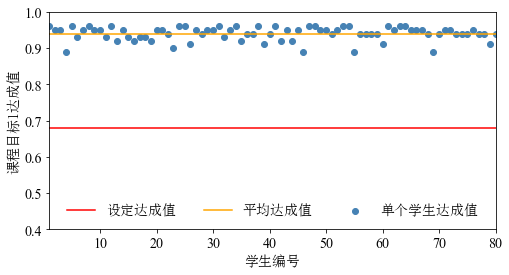

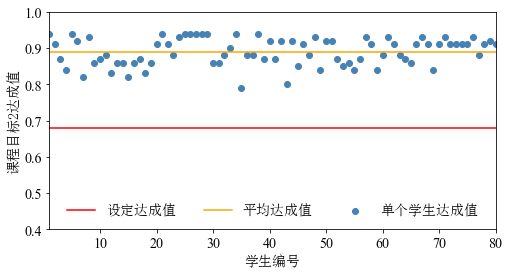

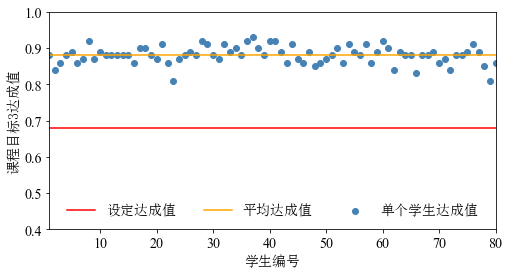

In [35]:

for i in [1,2,3]:
    Plot_Figure_Coursetarget_NumX(target_num=i, 
                                    W_value_allStudent_ADC_arr = W_value_allStudent_ADC_arr,
                                    W_mean_value_ADC_arr = W_mean_value_ADC_arr,
                                    W_Setting_ADC = W_Setting_ADC)

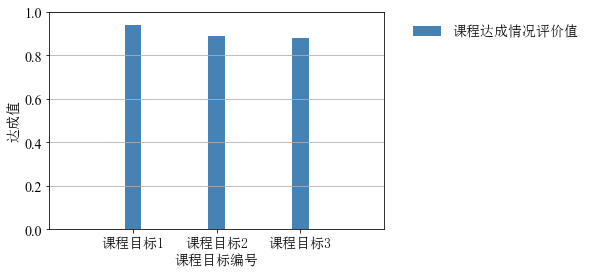

In [36]:

Num_coursetarget_arr = np.arange(1, Num_coursetarget+1, 1)  # 课程目标序列 
W_mean_value_ADC_arr   # 达成度平均值

# 绘图函数 - 课程目标num_X - 柱状图
#柱状图
fig, ax = plt.subplots( figsize=(6, 4) )
font_xylable = {'family':  'Times New Roman',
        'color':  'k',
        'weight': 'normal',
        'size': 14,
        }
        
font_legend = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 14,
        }
plt.grid(b=True, which = 'both',axis='y')

plt.bar(Num_coursetarget_arr, W_mean_value_ADC_arr , width=0.2 ,color='steelblue', label=f'课程达成情况评价值')


# ax.set_xlabel/ax.set_ylabel 设置 
ax.set_xlabel('课程目标编号', fontdict=font_xylable, rotation = 0, fontproperties=font_set)
ax.set_ylabel(f'达成值', fontdict=font_xylable, rotation =90, fontproperties=font_set) # rotation = 45 旋转45°

# X/Y轴的限制 + 刻度间隔
plt.xlim([0, Num_coursetarget+1])
plt.ylim([0, 1])

# 重定义X-label
nameconv_list = []
for i in np.arange(1, Num_coursetarget+1, 1):
        nameconv_list.append(f'课程目标{i}') 
plt.xticks(np.arange(1, Num_coursetarget+1, 1) , nameconv_list, rotation=0, fontproperties=font_set) # nameconv_list 

# legend 字体 + 大小
plt.legend(prop = font_set, frameon =False,ncol =3, bbox_to_anchor=(1.05,1.0)) # ncol =1/2 垂直/水平
# ax4.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)     ##设置ax4中legend的位置，将其放在图外
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=14)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 


# 保存
Figure_savepath = "课程目标绘图"
if not os.path.isdir(Figure_savepath):
    os.makedirs(Figure_savepath)
plt.savefig( os.path.join(Figure_savepath,f'图4-课程目标达成评价值'+'.png') , bbox_inches='tight', transparent=False, dpi = 600) 
plt.show() 
